# Visualizing attention maps in MNIST vision transformer
This notebook is designed to plot the attention maps of a vision transformer trained on MNIST digits.

In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [ ]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 66878536.89it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95382436.08it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69111227.22it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1991691.46it/s]

Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 195243380.83it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 76042494.55it/s]


Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21449812.35it/s]


Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15301629.53it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



In [ ]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


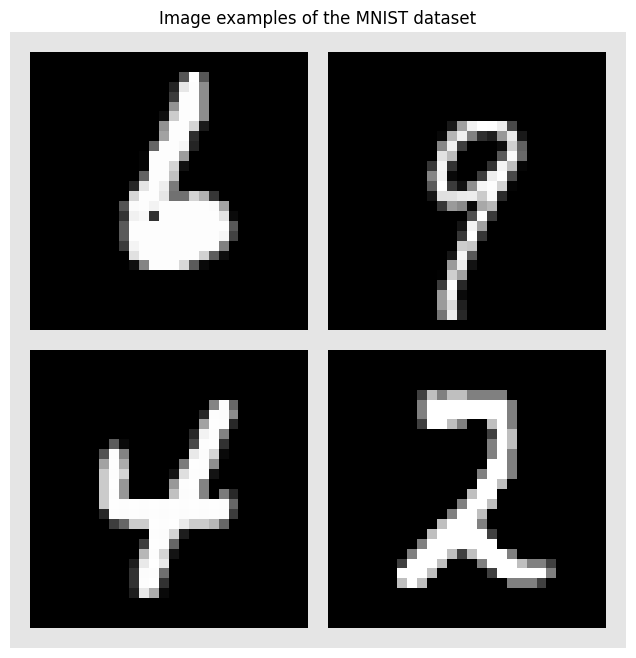

In [ ]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [ ]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
# attn_type = 1
dropout=0.2

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

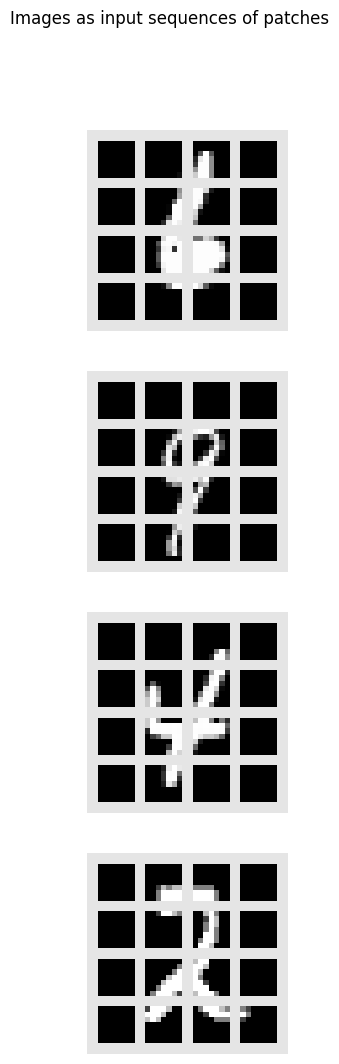

In [ ]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [ ]:
!pip install fairseq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 28.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11291804 sha256=91d4b4e0e03e0b5d63a3f7eaaccdaab4bc169106c810ff6a8dfe810a86bdb001
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.wh

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import math
from typing import Dict, Optional, Tuple

import torch
import torch.nn.functional as F
from fairseq import utils
from fairseq.incremental_decoding_utils import with_incremental_state
from fairseq.modules.quant_noise import quant_noise
from torch import Tensor, nn
from torch.nn import Parameter


@with_incremental_state
class MultiheadLinearAttention(nn.Module):
    """Multi-headed linformer attention.

    Projects the key and values down to the compressed dimension, before computing self-attention.

    See "Linformer: Self-Attention with Linear Complexity" for more details.
    """

    def __init__(
        self,
        embed_dim,
        num_heads,
        kdim=None,
        vdim=None,
        dropout=0.0,
        bias=True,
        add_bias_kv=False,
        add_zero_attn=False,
        self_attention=False,
        encoder_decoder_attention=False,
        q_noise=0.0,
        qn_block_size=8,
        compressed=1,
        max_seq_len=256,
        shared_kv_compressed=0,
        shared_compress_layer=None,
        freeze_compress=0,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self.qkv_same_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5

        self.self_attention = self_attention
        self.encoder_decoder_attention = encoder_decoder_attention

        assert not self.self_attention or self.qkv_same_dim, (
            "Self-attention requires query, key and " "value to be of the same size"
        )

        self.k_proj = quant_noise(
            nn.Linear(self.kdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.v_proj = quant_noise(
            nn.Linear(self.vdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.q_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        # used for compress sequence to subsequence
        if shared_compress_layer is None:
            self.compress_seq_len = max_seq_len // compressed
            self.compress_k = nn.Linear(max_seq_len, self.compress_seq_len, bias=False)
            if shared_kv_compressed == 0:
                self.compress_v = nn.Linear(
                    max_seq_len, self.compress_seq_len, bias=False
                )
            self.layerwise_sharing = False
        else:
            self.compress_k = shared_compress_layer
            if shared_kv_compressed == 0:
                self.compress_v = shared_compress_layer
            self.layerwise_sharing = True
        self.shared_kv_compressed = shared_kv_compressed

        self.out_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        if add_bias_kv:
            self.bias_k = Parameter(torch.Tensor(1, 1, embed_dim))
            self.bias_v = Parameter(torch.Tensor(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self.reset_parameters()

        if freeze_compress == 1:
            self.compress_k.weight.requires_grad = False
            if shared_kv_compressed == 0:
                self.compress_v.weight.requires_grad = False

        self.onnx_trace = False

    def prepare_for_onnx_export_(self):
        self.onnx_trace = True

    def reset_parameters(self):
        if self.qkv_same_dim:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
            if (
                not self.layerwise_sharing
            ):  # otherwise, we already initialize the parameters
                nn.init.xavier_uniform_(self.compress_k.weight, gain=1 / math.sqrt(2))
                if self.shared_kv_compressed == 0:
                    nn.init.xavier_uniform_(
                        self.compress_v.weight, gain=1 / math.sqrt(2)
                    )
        else:
            nn.init.xavier_uniform_(self.k_proj.weight)
            nn.init.xavier_uniform_(self.v_proj.weight)
            nn.init.xavier_uniform_(self.q_proj.weight)
            if (
                not self.layerwise_sharing
            ):  # otherwise, we already initialize the parameters
                nn.init.xavier_uniform_(self.compress_k.weight)
                if self.shared_kv_compressed == 0:
                    nn.init.xavier_uniform_(self.compress_v.weight)

        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def forward(
        self,
        query,
        key: Optional[Tensor],
        value: Optional[Tensor],
        key_padding_mask: Optional[Tensor] = None,
        incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
        need_weights: bool = True,
        static_kv: bool = False,
        attn_mask: Optional[Tensor] = None,
        before_softmax: bool = False,
        need_head_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        """Input shape: Time x Batch x Channel

        Args:
            key_padding_mask (ByteTensor, optional): mask to exclude
                keys that are pads, of shape `(batch, src_len)`, where
                padding elements are indicated by 1s.
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            attn_mask (ByteTensor, optional): typically used to
                implement causal attention, where the mask prevents the
                attention from looking forward in time (default: None).
            before_softmax (bool, optional): return the raw attention
                weights and values before the attention softmax.
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        tgt_len, bsz, embed_dim = query.size()
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]

        if incremental_state is not None:
            saved_state = self._get_input_buffer(incremental_state)
            if saved_state is not None and "prev_key" in saved_state:
                # previous time steps are cached - no need to recompute
                # key and value if they are static
                if static_kv:
                    assert self.encoder_decoder_attention and not self.self_attention
                    key = value = None
        else:
            saved_state = None

        if self.self_attention:
            q = self.q_proj(query)

            k_input = query.permute(1, 2, 0).contiguous()  # B * C * T
            k_input = (
                F.linear(k_input, self.compress_k.weight[:, 0:tgt_len])
                .permute(2, 0, 1)
                .contiguous()
            )
            k = self.k_proj(k_input)

            v_input = query.permute(1, 2, 0).contiguous()  # B * C * T
            if self.shared_kv_compressed == 0:
                v_input = (
                    F.linear(v_input, self.compress_v.weight[:, 0:tgt_len])
                    .permute(2, 0, 1)
                    .contiguous()
                )
            if self.shared_kv_compressed == 1:  # use shared kv compressed linear layer
                v_input = (
                    F.linear(v_input, self.compress_k.weight[:, 0:tgt_len])
                    .permute(2, 0, 1)
                    .contiguous()
                )
            v = self.v_proj(v_input)
        elif self.encoder_decoder_attention:
            # encoder-decoder attention
            q = self.q_proj(query)
            if key is None:
                assert value is None
                k = v = None
            else:
                k = self.k_proj(key)
                v = self.v_proj(key)

        else:
            assert key is not None and value is not None
            q = self.q_proj(query)
            k = self.k_proj(key)
            v = self.v_proj(value)
        q *= self.scaling

        if self.bias_k is not None:
            assert self.bias_v is not None
            k = torch.cat([k, self.bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, self.bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )
            if key_padding_mask is not None:
                key_padding_mask = torch.cat(
                    [
                        key_padding_mask,
                        key_padding_mask.new_zeros(key_padding_mask.size(0), 1),
                    ],
                    dim=1,
                )

        q = (
            q.contiguous()
            .view(tgt_len, bsz * self.num_heads, self.head_dim)
            .transpose(0, 1)
        )
        if k is not None:
            k = (
                k.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )
        if v is not None:
            v = (
                v.contiguous()
                .view(-1, bsz * self.num_heads, self.head_dim)
                .transpose(0, 1)
            )

        if saved_state is not None:
            # saved states are stored with shape (bsz, num_heads, seq_len, head_dim)
            if "prev_key" in saved_state:
                _prev_key = saved_state["prev_key"]
                assert _prev_key is not None
                prev_key = _prev_key.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    k = prev_key
                else:
                    assert k is not None
                    k = torch.cat([prev_key, k], dim=1)
            if "prev_value" in saved_state:
                _prev_value = saved_state["prev_value"]
                assert _prev_value is not None
                prev_value = _prev_value.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    v = prev_value
                else:
                    assert v is not None
                    v = torch.cat([prev_value, v], dim=1)
            prev_key_padding_mask: Optional[Tensor] = None
            if "prev_key_padding_mask" in saved_state:
                prev_key_padding_mask = saved_state["prev_key_padding_mask"]
            assert k is not None and v is not None
            key_padding_mask = MultiheadLinearAttention._append_prev_key_padding_mask(
                key_padding_mask=key_padding_mask,
                prev_key_padding_mask=prev_key_padding_mask,
                batch_size=bsz,
                src_len=k.size(1),
                static_kv=static_kv,
            )

            saved_state["prev_key"] = k.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_value"] = v.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_key_padding_mask"] = key_padding_mask
            # In this branch incremental_state is never None
            assert incremental_state is not None
            incremental_state = self._set_input_buffer(incremental_state, saved_state)
        assert k is not None
        src_len = k.size(1)

        if self.add_zero_attn:
            assert v is not None
            src_len += 1
            k = torch.cat([k, k.new_zeros((k.size(0), 1) + k.size()[2:])], dim=1)
            v = torch.cat([v, v.new_zeros((v.size(0), 1) + v.size()[2:])], dim=1)
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )

        attn_weights = torch.bmm(q, k.transpose(1, 2))
        attn_weights = MultiheadLinearAttention.apply_sparse_mask(
            attn_weights, tgt_len, src_len, bsz
        )

        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0)
            if self.onnx_trace:
                attn_mask = attn_mask.repeat(attn_weights.size(0), 1, 1)
            attn_weights += attn_mask

        if before_softmax:
            return attn_weights, v

        attn_weights_float = utils.softmax(
            attn_weights, dim=-1, onnx_trace=self.onnx_trace
        )
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = F.dropout(
            attn_weights,
            p=self.dropout,
            training=self.training,
        )
        assert v is not None
        attn = torch.bmm(attn_probs, v)
        assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]
        if self.onnx_trace and attn.size(1) == 1:
            # when ONNX tracing a single decoder step (sequence length == 1)
            # the transpose is a no-op copy before view, thus unnecessary
            attn = attn.contiguous().view(tgt_len, bsz, embed_dim)
        else:
            attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
        attn = self.out_proj(attn)
        attn_weights: Optional[Tensor] = None
        if need_weights:
            attn_weights = attn_weights_float.view(
                bsz, self.num_heads, tgt_len, src_len
            ).transpose(1, 0)
            if not need_head_weights:
                # average attention weights over heads
                attn_weights = attn_weights.mean(dim=0)

        return attn, attn_weights

    @staticmethod
    def _append_prev_key_padding_mask(
        key_padding_mask: Optional[Tensor],
        prev_key_padding_mask: Optional[Tensor],
        batch_size: int,
        src_len: int,
        static_kv: bool,
    ) -> Optional[Tensor]:
        # saved key padding masks have shape (bsz, seq_len)
        if prev_key_padding_mask is not None and static_kv:
            new_key_padding_mask = prev_key_padding_mask
        elif prev_key_padding_mask is not None and key_padding_mask is not None:
            new_key_padding_mask = torch.cat(
                [prev_key_padding_mask.float(), key_padding_mask.float()], dim=1
            )
        # During incremental decoding, as the padding token enters and
        # leaves the frame, there will be a time when prev or current
        # is None
        elif prev_key_padding_mask is not None:
            filler = torch.zeros(
                (batch_size, src_len - prev_key_padding_mask.size(1)),
                device=prev_key_padding_mask.device,
            )
            new_key_padding_mask = torch.cat(
                [prev_key_padding_mask.float(), filler.float()], dim=1
            )
        elif key_padding_mask is not None:
            filler = torch.zeros(
                (batch_size, src_len - key_padding_mask.size(1)),
                device=key_padding_mask.device,
            )
            new_key_padding_mask = torch.cat(
                [filler.float(), key_padding_mask.float()], dim=1
            )
        else:
            new_key_padding_mask = prev_key_padding_mask
        return new_key_padding_mask

    @torch.jit.export
    def reorder_incremental_state(
        self,
        incremental_state: Dict[str, Dict[str, Optional[Tensor]]],
        new_order: Tensor,
    ):
        """Reorder buffered internal state (for incremental generation)."""
        input_buffer = self._get_input_buffer(incremental_state)
        if input_buffer is not None:
            for k in input_buffer.keys():
                input_buffer_k = input_buffer[k]
                if input_buffer_k is not None:
                    if self.encoder_decoder_attention and input_buffer_k.size(
                        0
                    ) == new_order.size(0):
                        break
                    input_buffer[k] = input_buffer_k.index_select(0, new_order)
            incremental_state = self._set_input_buffer(incremental_state, input_buffer)
        return incremental_state

    def _get_input_buffer(
        self, incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]]
    ) -> Dict[str, Optional[Tensor]]:
        result = self.get_incremental_state(incremental_state, "attn_state")
        if result is not None:
            return result
        else:
            empty_result: Dict[str, Optional[Tensor]] = {}
            return empty_result

    def _set_input_buffer(
        self,
        incremental_state: Dict[str, Dict[str, Optional[Tensor]]],
        buffer: Dict[str, Optional[Tensor]],
    ):
        return self.set_incremental_state(incremental_state, "attn_state", buffer)

    def apply_sparse_mask(attn_weights, tgt_len: int, src_len: int, bsz: int):
        return attn_weights

    def upgrade_state_dict_named(self, state_dict, name):
        prefix = name + "." if name != "" else ""
        items_to_add = {}
        keys_to_remove = []
        for k in state_dict.keys():
            if k.endswith(prefix + "in_proj_weight"):
                # in_proj_weight used to be q + k + v with same dimensions
                dim = int(state_dict[k].shape[0] / 3)
                items_to_add[prefix + "q_proj.weight"] = state_dict[k][:dim]
                items_to_add[prefix + "k_proj.weight"] = state_dict[k][dim : 2 * dim]
                items_to_add[prefix + "v_proj.weight"] = state_dict[k][2 * dim :]

                keys_to_remove.append(k)

                k_bias = prefix + "in_proj_bias"
                if k_bias in state_dict.keys():
                    dim = int(state_dict[k].shape[0] / 3)
                    items_to_add[prefix + "q_proj.bias"] = state_dict[k_bias][:dim]
                    items_to_add[prefix + "k_proj.bias"] = state_dict[k_bias][
                        dim : 2 * dim
                    ]
                    items_to_add[prefix + "v_proj.bias"] = state_dict[k_bias][2 * dim :]

                    keys_to_remove.append(prefix + "in_proj_bias")

        for k in keys_to_remove:
            del state_dict[k]

        for key, value in items_to_add.items():
            state_dict[key] = value

In [ ]:
class LinearAttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, kdim=None, vdim=None, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = MultiheadLinearAttention(embed_dim, num_heads, kdim=kdim, vdim=vdim)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        attn_type = 0,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        if attn_type==0:
          self.transformer = nn.Sequential(
              *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
          )
        elif attn_type==1:
          self.transformer = nn.Sequential(
              *(LinearAttentionBlock(embed_dim, hidden_dim, num_heads, kdim=embed_dim, vdim=embed_dim, dropout=dropout) for _ in range(num_layers))
          )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

### Transformer

In [ ]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          attn_type=0,
                          dropout=dropout,)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [ ]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

In [ ]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2563 valid 0.1493


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2312 valid 0.1169


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4363 valid 0.0965


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0094 valid 0.0883


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0082 valid 0.0900


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0067 valid 0.0780


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0291 valid 0.0689


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0276 valid 0.0813


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0227 valid 0.0730


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1695 valid 0.0689


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0364 valid 0.0750


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0015 valid 0.0712


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0008 valid 0.0778


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0033 valid 0.0718


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0675 valid 0.0796


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0027 valid 0.0765


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0101 valid 0.0729


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0011 valid 0.0636


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0148 valid 0.0618


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0010 valid 0.0599


Text(0.5, 1.0, 'Training loss')

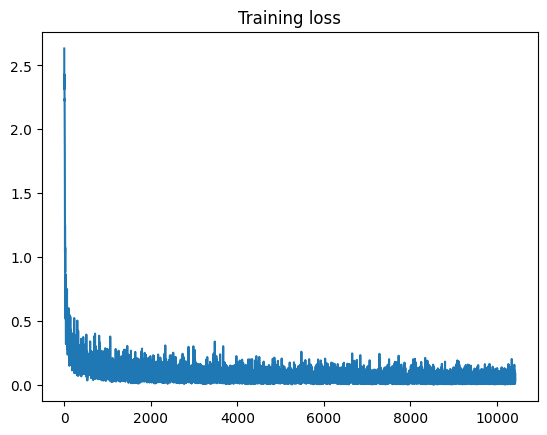

In [ ]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [ ]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.9821


### Linformer scratch

In [ ]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          attn_type=1,
                          dropout=dropout,)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [ ]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): LinearAttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadLinearAttention(
        (k_proj): Linear(in_features=256, out_features=256, bias=True)
        (v_proj): Linear(in_features=256, out_features=256, bias=True)
        (q_proj): Linear(in_features=256, out_features=256, bias=True)
        (compress_k): Linear(in_features=256, out_features=256, bias=False)
        (compress_v): Linear(in_features=256, out_features=256, bias=False)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, ou

In [ ]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionLinformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1398 valid 0.1599


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0199 valid 0.0938


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0436 valid 0.1018


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0421 valid 0.0883


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0024 valid 0.0806


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2424 valid 0.0749


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0035 valid 0.0809


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0172 valid 0.0826


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0180 valid 0.0686


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0869 valid 0.0637


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1578 valid 0.0664


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4646 valid 0.0658


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0021 valid 0.0645


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0014 valid 0.0721


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0036 valid 0.0720


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0066 valid 0.0816


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0046 valid 0.0751


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0015 valid 0.0775


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0736 valid 0.0763


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2481 valid 0.0647


Text(0.5, 1.0, 'Training loss')

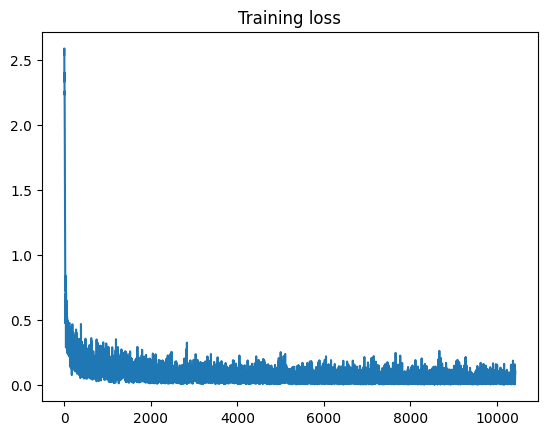

In [ ]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [ ]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.9808


### Linformer from checkpoint

In [ ]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          attn_type=1,
                          dropout=dropout,)

# Transfer to GPU
model.to(device)
model_restore = '/model_VisionLinformer_MNIST_20.pt'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [ ]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=256, bias=True)
  (transformer): Sequential(
    (0): LinearAttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadLinearAttention(
        (k_proj): Linear(in_features=256, out_features=256, bias=True)
        (v_proj): Linear(in_features=256, out_features=256, bias=True)
        (q_proj): Linear(in_features=256, out_features=256, bias=True)
        (compress_k): Linear(in_features=256, out_features=256, bias=False)
        (compress_v): Linear(in_features=256, out_features=256, bias=False)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=768, ou

In [ ]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(10):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionLinformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0020 valid 0.0876


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3121 valid 0.0875


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0026 valid 0.0746


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0010 valid 0.0722


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2875 valid 0.0751


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0036 valid 0.0744


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0151 valid 0.0817


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0627 valid 0.0734


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0003 valid 0.0667


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0011 valid 0.0817


In [ ]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.978
